# Stroke Prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, f1_score, roc_curve, precision_recall_curve
from sklearn.inspection import PartialDependenceDisplay

# Load dataset

In [3]:
df = pd.read_csv(r"C:\Users\biswa\OneDrive\Desktop\PROJECT\StrokePrediction\DATASET.csv")
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


# -----------------------------
# Data Cleaning and Preprocessing
# -----------------------------

# Replace 'N/A' with np.nan

In [4]:
df.replace("N/A", np.nan, inplace=True)

# Convert bmi to float

In [5]:
df['bmi'] = df['bmi'].astype(float)

# Drop rows with missing values

In [6]:
df.dropna(inplace=True)

# Encode 'gender': Male = 1, Female = 0

In [7]:
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# Encode 'Residence_type': Urban = 1, Rural = 0

In [8]:
df['Residence_type'] = df['Residence_type'].map({'Urban': 1, 'Rural': 0})

# One-hot encode 'work_type'

In [9]:
# Drop unneeded columns
df.drop(columns=['id', 'ever_married'], inplace=True, errors='ignore')

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['work_type', 'smoking_status'], prefix=['work', 'smoke'])

# --- EDA Section ---
# Plot distribution of stroke

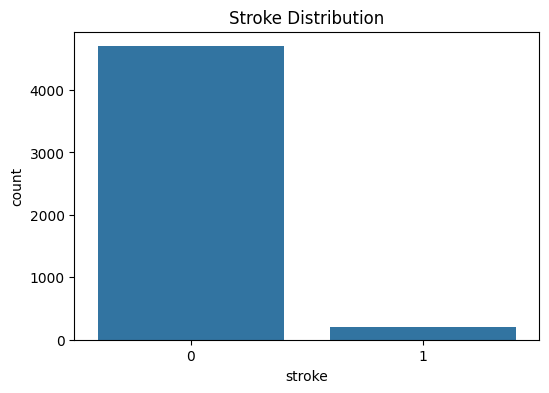

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='stroke')
plt.title("Stroke Distribution")
plt.show()

# Age distribution by stroke

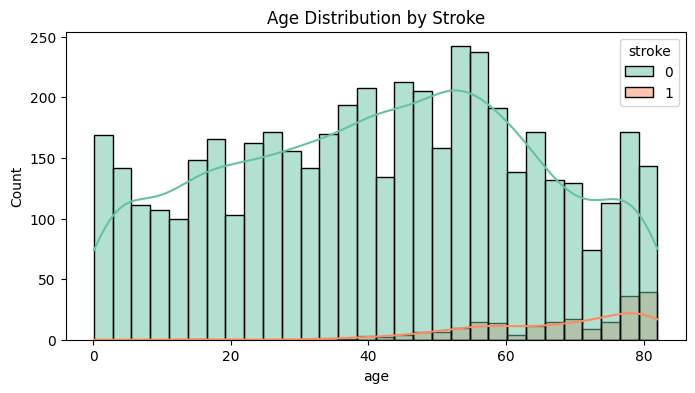

In [11]:
# Age distribution by stroke
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='age', hue='stroke', bins=30, kde=True, palette='Set2')
plt.title("Age Distribution by Stroke")
plt.show()

# Glucose level vs Stroke

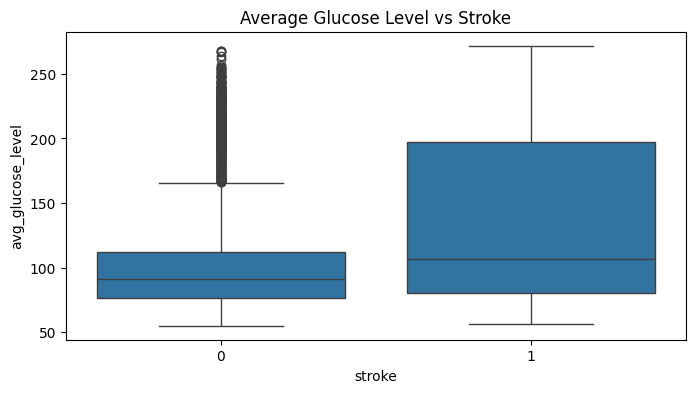

In [12]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='stroke', y='avg_glucose_level')
plt.title("Average Glucose Level vs Stroke")
plt.show()

# BMI distribution by stroke

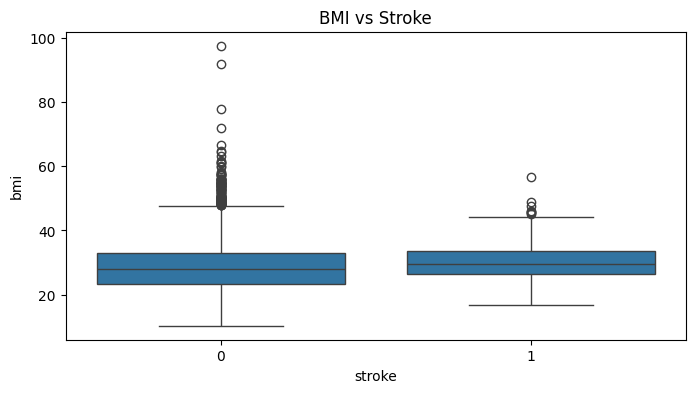

In [13]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='stroke', y='bmi')
plt.title("BMI vs Stroke")
plt.show()

# Correlation matrix (excluding non-numeric columns)

In [14]:
df

,gender,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,stroke,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children,smoke_Unknown,smoke_formerly smoked,smoke_never smoked,smoke_smokes
0,1.0,67.0,0,1,1,228.69,36.6,1,False,False,True,False,False,False,True,False,False
2,1.0,80.0,0,1,0,105.92,32.5,1,False,False,True,False,False,False,False,True,False
3,0.0,49.0,0,0,1,171.23,34.4,1,False,False,True,False,False,False,False,False,True
4,0.0,79.0,1,0,0,174.12,24.0,1,False,False,False,True,False,False,False,True,False
5,1.0,81.0,0,0,1,186.21,29.0,1,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0.0,13.0,0,0,0,103.08,18.6,0,False,False,False,False,True,True,False,False,False
5106,0.0,81.0,0,0,1,125.20,40.0,0,False,False,False,True,False,False,False,True,False
5107,0.0,35.0,0,0,0,82.99,30.6,0,False,False,False,True,False,False,False,True,False
5108,1.0,51.0,0,0,0,166.29,25.6,0,False,False,True,False,False,False,True,False,False


# Convert all boolean values in the DataFrame to integers

In [15]:
# Convert all boolean values in the DataFrame to integers
df = df.applymap(lambda x: int(x) if type(x) == bool else x)

C:\Users\biswa\AppData\Local\Temp\ipykernel_8476\2167914997.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: int(x) if type(x) == bool else x)


In [16]:
df

,gender,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,stroke,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children,smoke_Unknown,smoke_formerly smoked,smoke_never smoked,smoke_smokes
0,1.0,67.0,0,1,1,228.69,36.6,1,0,0,1,0,0,0,1,0,0
2,1.0,80.0,0,1,0,105.92,32.5,1,0,0,1,0,0,0,0,1,0
3,0.0,49.0,0,0,1,171.23,34.4,1,0,0,1,0,0,0,0,0,1
4,0.0,79.0,1,0,0,174.12,24.0,1,0,0,0,1,0,0,0,1,0
5,1.0,81.0,0,0,1,186.21,29.0,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0.0,13.0,0,0,0,103.08,18.6,0,0,0,0,0,1,1,0,0,0
5106,0.0,81.0,0,0,1,125.20,40.0,0,0,0,0,1,0,0,0,1,0
5107,0.0,35.0,0,0,0,82.99,30.6,0,0,0,0,1,0,0,0,1,0
5108,1.0,51.0,0,0,0,166.29,25.6,0,0,0,1,0,0,0,1,0,0


# One-hot encode 'smoking_status'

In [17]:
df

,gender,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,stroke,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children,smoke_Unknown,smoke_formerly smoked,smoke_never smoked,smoke_smokes
0,1.0,67.0,0,1,1,228.69,36.6,1,0,0,1,0,0,0,1,0,0
2,1.0,80.0,0,1,0,105.92,32.5,1,0,0,1,0,0,0,0,1,0
3,0.0,49.0,0,0,1,171.23,34.4,1,0,0,1,0,0,0,0,0,1
4,0.0,79.0,1,0,0,174.12,24.0,1,0,0,0,1,0,0,0,1,0
5,1.0,81.0,0,0,1,186.21,29.0,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0.0,13.0,0,0,0,103.08,18.6,0,0,0,0,0,1,1,0,0,0
5106,0.0,81.0,0,0,1,125.20,40.0,0,0,0,0,1,0,0,0,1,0
5107,0.0,35.0,0,0,0,82.99,30.6,0,0,0,0,1,0,0,0,1,0
5108,1.0,51.0,0,0,0,166.29,25.6,0,0,0,1,0,0,0,1,0,0


In [18]:
df = df.applymap(lambda x: int(x) if type(x) == bool else x)


C:\Users\biswa\AppData\Local\Temp\ipykernel_8476\2906927793.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: int(x) if type(x) == bool else x)


In [19]:
df

,gender,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,stroke,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children,smoke_Unknown,smoke_formerly smoked,smoke_never smoked,smoke_smokes
0,1.0,67.0,0,1,1,228.69,36.6,1,0,0,1,0,0,0,1,0,0
2,1.0,80.0,0,1,0,105.92,32.5,1,0,0,1,0,0,0,0,1,0
3,0.0,49.0,0,0,1,171.23,34.4,1,0,0,1,0,0,0,0,0,1
4,0.0,79.0,1,0,0,174.12,24.0,1,0,0,0,1,0,0,0,1,0
5,1.0,81.0,0,0,1,186.21,29.0,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0.0,13.0,0,0,0,103.08,18.6,0,0,0,0,0,1,1,0,0,0
5106,0.0,81.0,0,0,1,125.20,40.0,0,0,0,0,1,0,0,0,1,0
5107,0.0,35.0,0,0,0,82.99,30.6,0,0,0,0,1,0,0,0,1,0
5108,1.0,51.0,0,0,0,166.29,25.6,0,0,0,1,0,0,0,1,0,0


In [20]:
scaler = StandardScaler()
df[['age', 'bmi', 'avg_glucose_level']] = scaler.fit_transform(df[['age', 'bmi', 'avg_glucose_level']])

In [21]:
df

,gender,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,stroke,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children,smoke_Unknown,smoke_formerly smoked,smoke_never smoked,smoke_smokes
0,1.0,1.070138,0,1,1,2.777698,0.981345,1,0,0,1,0,0,0,1,0,0
2,1.0,1.646563,0,1,0,0.013842,0.459269,1,0,0,1,0,0,0,0,1,0
3,0.0,0.272012,0,0,1,1.484132,0.701207,1,0,0,1,0,0,0,0,0,1
4,0.0,1.602222,1,0,0,1.549193,-0.623083,1,0,0,0,1,0,0,0,1,0
5,1.0,1.690903,0,0,1,1.821368,0.013595,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0.0,-1.324241,0,0,0,-0.050094,-1.310695,0,0,0,0,0,1,1,0,0,0
5106,0.0,1.690903,0,0,1,0.447882,1.414286,0,0,0,0,1,0,0,0,1,0
5107,0.0,-0.348753,0,0,0,-0.502369,0.217332,0,0,0,0,1,0,0,0,1,0
5108,1.0,0.360692,0,0,0,1.372920,-0.419346,0,0,0,1,0,0,0,1,0,0


In [22]:
x = df.drop('stroke', axis = 1)
y = df['stroke']

In [23]:
x

,gender,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children,smoke_Unknown,smoke_formerly smoked,smoke_never smoked,smoke_smokes
0,1.0,1.070138,0,1,1,2.777698,0.981345,0,0,1,0,0,0,1,0,0
2,1.0,1.646563,0,1,0,0.013842,0.459269,0,0,1,0,0,0,0,1,0
3,0.0,0.272012,0,0,1,1.484132,0.701207,0,0,1,0,0,0,0,0,1
4,0.0,1.602222,1,0,0,1.549193,-0.623083,0,0,0,1,0,0,0,1,0
5,1.0,1.690903,0,0,1,1.821368,0.013595,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0.0,-1.324241,0,0,0,-0.050094,-1.310695,0,0,0,0,1,1,0,0,0
5106,0.0,1.690903,0,0,1,0.447882,1.414286,0,0,0,1,0,0,0,1,0
5107,0.0,-0.348753,0,0,0,-0.502369,0.217332,0,0,0,1,0,0,0,1,0
5108,1.0,0.360692,0,0,0,1.372920,-0.419346,0,0,1,0,0,0,1,0,0


In [24]:
y

0       1
2       1
3       1
4       1
5       1
       ..
5104    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 4909, dtype: int64

# Train-test split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest

In [26]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Predict and evaluate

In [27]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

C:\Users\biswa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\biswa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\biswa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [28]:
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

Accuracy: 0.9460
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982



# 🎯 Feature Importance Plot

In [29]:
importances = model.feature_importances_
features = x.columns
indices = np.argsort(importances)[::-1]

C:\Users\biswa\AppData\Local\Temp\ipykernel_8476\1852656114.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=features[indices], palette='viridis')


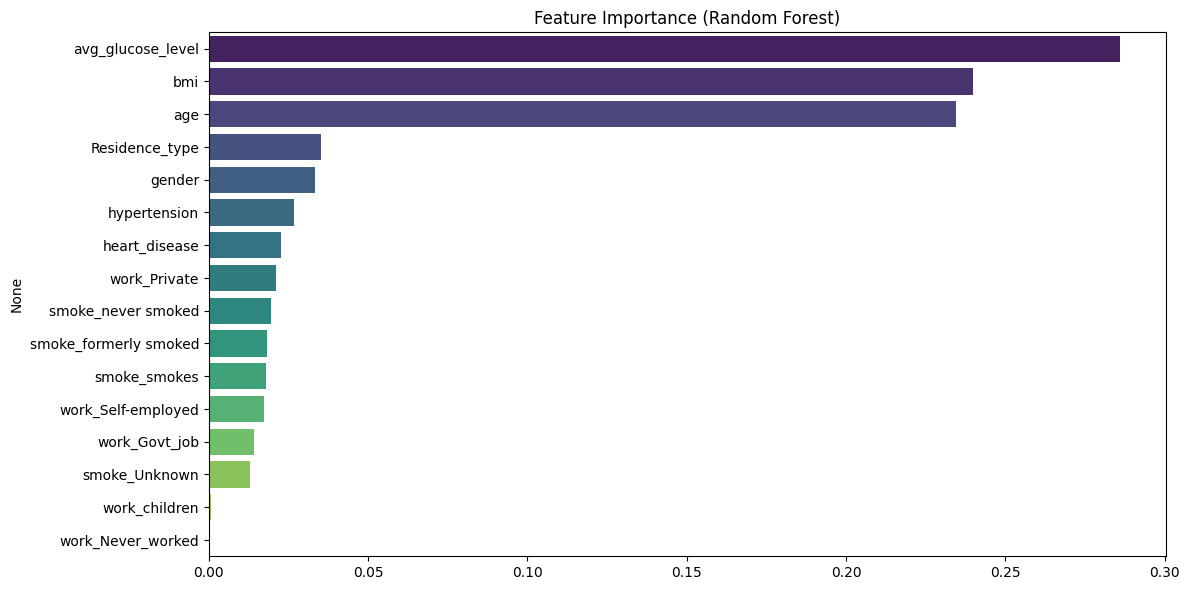

In [30]:
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=features[indices], palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

# 📊 Confusion Matrix

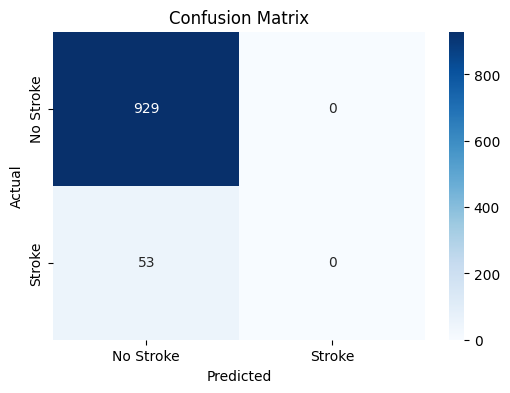

In [31]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [32]:
# import pickle

# # Save model
# with open("stroke_prediction_model.pkl", "wb") as file:
#     pickle.dump(model, file)

# # Optionally, save scaler too if needed for real-world input scaling
# with open("scaler.pkl", "wb") as file:
#     pickle.dump(scaler, file)
# joblib.dump(X.columns.tolist(), 'columns.pkl')


In [33]:
import joblib

# Export the trained model
joblib.dump(model, 'stroke_prediction_model.pkl')

# Save the scaler and column names
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(x.columns.tolist(), 'columns.pkl')


['columns.pkl']